# Assessing Wikipedia Bias

## Introduction

Wikipedia is one of the most widely used information platforms in the world, offering free access to knowledge on nearly every imaginable topic. One of the reasons it is so widely used is that anyone can contribute to it, and thus making it knowledge accessible, but also introduces challenges. Since so many different people contribute, it is easy for bias to slip into articles.

While Wikipedia does have policies to outright information, it is harder to catch and correct subtle bias in the way information is written. Thus, in reality language can reflect personal opinions, cultural viewpoints, or even political leanings. These influences can affect how information is presented, which might shape how readers understand a topic.

The goal of this project is to inverstigate and quantify this bias. Through a combination of data collection, exploratory data analysis (EDA), and supervised learning techniques, we aim to build a model capable of identifying biased language in Wikipedia articles - mostly at the sentence level. This will get us an overall 'bias score' for an article, offering a scalable and interpretable way to assess objectivity.

## Data Overview

In [76]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import random

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from nltk.tokenize import sent_tokenize



from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


from wordcloud import WordCloud

import xgboost as xgb
from textblob import TextBlob

from sklearn.model_selection import GridSearchCV

from tqdm import tqdm


In [77]:
# Load the datasets
data = pd.read_csv('final_labels.csv', sep=';')

# Display the first few rows of the dataset
display(data.head())

,text,news_link,outlet,topic,type,label_bias,label_opinion,biased_words
0,"""Orange Is the New Black"" star Yael Stone is r...",https://www.foxnews.com/entertainment/australi...,Fox News,environment,right,Non-biased,Entirely factual,[]
1,"""We have one beautiful law,"" Trump recently sa...",https://www.alternet.org/2020/06/law-and-order...,Alternet,gun control,left,Biased,Somewhat factual but also opinionated,"['bizarre', 'characteristically']"
2,"...immigrants as criminals and eugenics, all o...",https://www.nbcnews.com/news/latino/after-step...,MSNBC,white-nationalism,left,Biased,Expresses writer’s opinion,"['criminals', 'fringe', 'extreme']"
3,...we sounded the alarm in the early months of...,https://www.alternet.org/2019/07/fox-news-has-...,Alternet,white-nationalism,left,Biased,Somewhat factual but also opinionated,[]
4,[Black Lives Matter] is essentially a non-fals...,http://feedproxy.google.com/~r/breitbart/~3/-v...,Breitbart,marriage-equality,NaN,Biased,Expresses writer’s opinion,['cult']


### Data preprocessing

In [78]:
# Display the column names of the dataset
column_names = data.columns.tolist()
display(column_names)

['text',
 'news_link',
 'outlet',
 'topic',
 'type',
 'label_bias',
 'label_opinion',
 'biased_words']

In [79]:
# Display the shape of the dataset
n_rows, n_cols = data.shape
print(f"The DataFrame has {n_rows} rows and {n_cols} columns")

The DataFrame has 3674 rows and 8 columns


In [80]:
# Display the informative summary of the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3674 entries, 0 to 3673
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text           3674 non-null   object
 1   news_link      3642 non-null   object
 2   outlet         3674 non-null   object
 3   topic          3674 non-null   object
 4   type           2674 non-null   object
 5   label_bias     3674 non-null   object
 6   label_opinion  3674 non-null   object
 7   biased_words   3674 non-null   object
dtypes: object(8)
memory usage: 229.8+ KB


In [81]:
# Display the descriptive statistics of the dataset

data.describe()

,text,news_link,outlet,topic,type,label_bias,label_opinion,biased_words
count,3674,3642,3674,3674,2674,3674,3674,3674
unique,3674,2095,11,23,3,3,4,1623
top,"""Orange Is the New Black"" star Yael Stone is r...",http://feedproxy.google.com/~r/breitbart/~3/MB...,Breitbart,marriage-equality,right,Non-biased,Entirely factual,[]
freq,1,15,943,347,993,1863,1600,1825


## Explorating Data Analysis

### Duplicates

In [82]:
# Display the number of duplicates in the dataset
duplicates = data[data.duplicated()]
display(f"Number of duplicated data: {duplicates.shape[0]}")

'Number of duplicated data: 0'

### Missing Values

In [83]:
# Display the number of missing values in the dataset
display(data.isna().sum())

# Check for missing values in the DataFrame as a percentage
display(data.isna().sum()/len(data))

text                0
news_link          32
outlet              0
topic               0
type             1000
label_bias          0
label_opinion       0
biased_words        0
dtype: int64

text             0.000000
news_link        0.008710
outlet           0.000000
topic            0.000000
type             0.272183
label_bias       0.000000
label_opinion    0.000000
biased_words     0.000000
dtype: float64

In [84]:
# Drop rows with missing values in the 'news_link' and 'article' columns
data.dropna(subset=['news_link'], inplace=True)
data.dropna(subset=['type'], inplace=True)

In [85]:
# Check for missing values in the DataFrame as a percentage
display(data.isna().sum()/len(data))

text             0.0
news_link        0.0
outlet           0.0
topic            0.0
type             0.0
label_bias       0.0
label_opinion    0.0
biased_words     0.0
dtype: float64

In [86]:
# Cleaning the text data in the 'text' column
# Define a function to clean the text data
def clear_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-z\s]","", text)
    text = text.split()
    return " ".join(text)

In [87]:
data['label_bias'] = data['label_bias'].str.lower()
data['topic'] = data['topic'].str.replace('-', ' ').str.lower()

In [88]:
data['biased_words'] = data['biased_words'].str.replace(r"[\[\]']", "", regex=True).str.replace(",", " ").str.strip()

In [89]:
# Apply the clear_text function to the 'comment_text' column
data['clean_text'] = data['text'].astype(str).apply(clear_text)
data= data.drop(columns=['text'])

# Display the first 5 rows of the comments DataFrame after cleaning
display(data.sample(5))


,news_link,outlet,topic,type,label_bias,label_opinion,biased_words,clean_text
816,https://eu.usatoday.com/story/news/politics/20...,USA Today,gender,center,non-biased,Entirely factual,,democrats and republicans stood and applauded ...
3426,https://www.breitbart.com/sports/2020/02/22/uf...,Breitbart,sport,right,biased,Expresses writer’s opinion,terrible,ufc middleweight champion israel adesanyas com...
1504,https://www.msnbc.com/rachel-maddow-show/even-...,MSNBC,environment,left,biased,Expresses writer’s opinion,polluters,it wasnt long after donald trump and his team ...
158,https://www.alternet.org/2020/02/new-report-re...,Alternet,universal health care,left,non-biased,Entirely factual,,according to lauren copeland a political scien...
2741,https://www.breitbart.com/politics/2019/01/07/...,Breitbart,abortion,right,biased,Somewhat factual but also opinionated,,the legislation ends criminal penalties for se...


In [90]:
# Check for missing values
print(data['clean_text'].isna().sum())

0


In [91]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2644 entries, 0 to 3673
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   news_link      2644 non-null   object
 1   outlet         2644 non-null   object
 2   topic          2644 non-null   object
 3   type           2644 non-null   object
 4   label_bias     2644 non-null   object
 5   label_opinion  2644 non-null   object
 6   biased_words   2644 non-null   object
 7   clean_text     2644 non-null   object
dtypes: object(8)
memory usage: 185.9+ KB


In [92]:
  >>> import nltk
  >>> nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jeelf\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [93]:
## Set of English stop words
stop_words =  set(stopwords.words('english'))

In [94]:
# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatize(text):
    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token not in stop_words]
    lemmas = [lemmatizer.lemmatize(token) for token in tokens]
    return " ".join(lemmas)

In [95]:

  >>> import nltk
  >>> nltk.download('punkt_tab')


  >>> import nltk
  >>> nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\jeelf\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jeelf\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [96]:
# Apply the clear_text function to the 'comment_text' column
data['lemmatize_text'] = data['clean_text'].apply(lemmatize)

In [97]:
# Display the first 5 rows of the comments DataFrame after cleaning
display(data[['clean_text', 'lemmatize_text']].head(20))

,clean_text,lemmatize_text
0,orange is the new black star yael stone is ren...,orange new black star yael stone renouncing u ...
1,we have one beautiful law trump recently said ...,one beautiful law trump recently said characte...
2,immigrants as criminals and eugenics all of wh...,immigrant criminal eugenics considered fringe ...
3,we sounded the alarm in the early months of tr...,sounded alarm early month trump presidency pri...
9,a new low washington post media critic blows u...,new low washington post medium critic blow tuc...
10,gangster capitalist trump is running a mafia s...,gangster capitalist trump running mafia state ...
11,the most progressive president since fdr biden...,progressive president since fdr bidens policy ...
18,the goal is to send a message of peace the yea...,goal send message peace yearold claimed insist...
20,you know theres over million people with preex...,know there million people preexisting conditio...
21,people were arrested for offences including as...,people arrested offence including assaulting p...


In [98]:
# Added a new column to convert 'biased' to 1 and 'non-biased' to 0
data['is_biased'] = data['label_bias'].apply(lambda x: 1 if x == 'biased' else 0)


In [99]:
# Making sure the new column 'is_biased' is present in the dataset
data.head()

,news_link,outlet,topic,type,label_bias,label_opinion,biased_words,clean_text,lemmatize_text,is_biased
0,https://www.foxnews.com/entertainment/australi...,Fox News,environment,right,non-biased,Entirely factual,,orange is the new black star yael stone is ren...,orange new black star yael stone renouncing u ...,0
1,https://www.alternet.org/2020/06/law-and-order...,Alternet,gun control,left,biased,Somewhat factual but also opinionated,bizarre characteristically,we have one beautiful law trump recently said ...,one beautiful law trump recently said characte...,1
2,https://www.nbcnews.com/news/latino/after-step...,MSNBC,white nationalism,left,biased,Expresses writer’s opinion,criminals fringe extreme,immigrants as criminals and eugenics all of wh...,immigrant criminal eugenics considered fringe ...,1
3,https://www.alternet.org/2019/07/fox-news-has-...,Alternet,white nationalism,left,biased,Somewhat factual but also opinionated,,we sounded the alarm in the early months of tr...,sounded alarm early month trump presidency pri...,1
9,https://www.alternet.org/2019/08/a-new-low-was...,Alternet,white nationalism,left,biased,Expresses writer’s opinion,blows up absurd lies nationalism white,a new low washington post media critic blows u...,new low washington post medium critic blow tuc...,1


In [100]:
# Display the shape of the dataset after completing EDA.
n_rows, n_cols = data.shape
print(f"The DataFrame has {n_rows} rows and {n_cols} columns")

The DataFrame has 2644 rows and 10 columns


### Conclusion: Data Preprocessing and EDA

In this part, we conducted a thorough preprocessing and exploratory data analysis (EDA) to prepare the dataset for bias detection modeling. Firstly, we reviewed the dataset's structure, identifying the number of rows and columns, and inspecting its basic information and summary statistics. We then addressed data quality issues, including duplicates, and handling missing values. Doing this, there were no duplicates found in the data, while missing values were found in two columns 'news_link' and 'type' in negligible percentage of the dataset. Thus, rows will missing values were dropped.

Next, we focused on cleaning and standarizing the text data. This included lowercasing, removing URLs, special characters, and stopwords, as well as lemmatizing words to reduce them to their root forms. These steps help normalize the text and reduce noise, which is essential for any NLP-based modeling.

To better analyze bias, we created a binary label column ('is_biased') to distinguish between biased and unbiased texts. This will serve as our target variable in supervised which will be used as input features for further linguistic anaylsis and model training.

Overall, the dataset is now well-structured, cleaned, and ready for feature extraction, model building, and further investigation into biased language patterns.

#### Which topics have the most biased words on average per article?

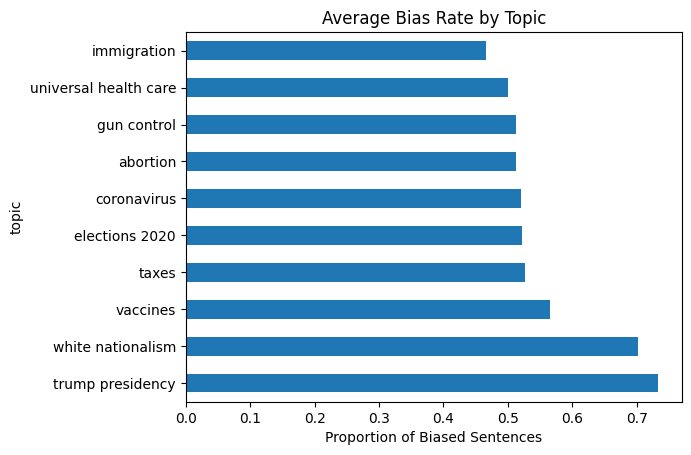

In [101]:
bias_by_topic = data.groupby('topic')['is_biased'].mean().sort_values(ascending=False).head(10)
bias_by_topic.plot(kind='barh')
plt.title('Average Bias Rate by Topic')
plt.xlabel('Proportion of Biased Sentences')
plt.show()

The graph above reveals that certain topics attract more biased language than others. 'Trump presidency' and 'white nationalism' have the highest average bias rates, with over 70% of sentences labeled as biased. These findings suggest that politically and socially charged topics are more prone to emotionally loaded language. On the other hand, topics like 'immigration', 'universal healthercare', and 'gun control' show lower bias rates, though they still remain near 45-50%, indicating that even these texts are not free from bias.

Understanding which topics are more likely to contain biased language helps contextualize the limitations of people-contributed platforms like Wikipedia and can inform targeted moderation or review efforts.

#### Is the dataset balanced between biased and unbiased data rows?

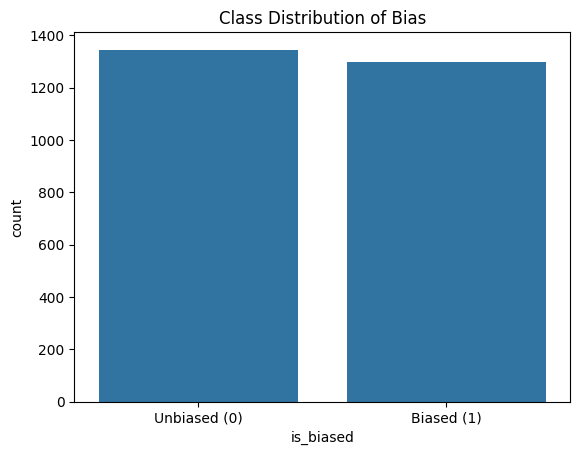

In [102]:
sns.countplot(x='is_biased', data=data)
plt.title('Class Distribution of Bias')
plt.xticks([0,1], ['Unbiased (0)', 'Biased (1)'])
plt.show()

The graph indicates that the dataset is nearly balanced, with a slightly higher number of unbiased (0) data rows compared to biased (1). This is ideal for supervising learning, as a balanced dataset helps prevent the model from becoming biased toward the majority class. It increases the likelihood of accurate predictions for both biased and unbiased text during model training and evaluation.

#### Which words are most frequently flagged as biased across the dataset?

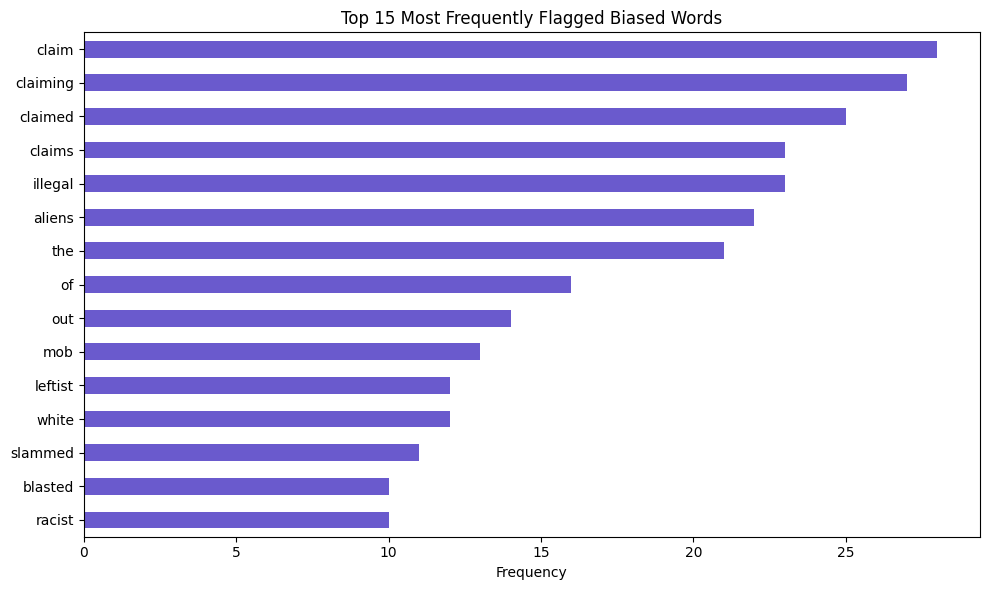

In [103]:
all_biased_words = data['biased_words'].dropna().astype(str).str.split()

all_biased_words = [word for sublist in all_biased_words for word in sublist]

top_words = pd.Series(all_biased_words).value_counts().head(15)

# Plot
top_words.plot(kind='barh', figsize=(10,6), color='slateblue')
plt.xlabel('Frequency')
plt.title('Top 15 Most Frequently Flagged Biased Words')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

#### How does sentiment differ between biased and unbiased texts?

#### What proportion of an article's sentences are labeled as biased or opinionated?

#### Which news outlet have the highest average bias score?



## Modeling

In [104]:
# Before modeling, checking the total counts for 'biased' and 'non-biased'.
data['is_biased'].value_counts()

is_biased
0    1345
1    1299
Name: count, dtype: int64

### TF-IDF & Logistic Regression:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    data['lemmatize_text'], data['is_biased'], test_size=0.2, random_state=42
)

In [ ]:
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)


In [ ]:
X_train.shape

(2115,)

In [ ]:
X_train_vec.shape

(2115, 5000)

In [ ]:
y_train.shape

(2115,)

In [ ]:
model = LogisticRegression()
model.fit(X_train_vec, y_train)

y_pred = model.predict(X_test_vec)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.722117202268431
[[199  65]
 [ 82 183]]
              precision    recall  f1-score   support

           0       0.71      0.75      0.73       264
           1       0.74      0.69      0.71       265

    accuracy                           0.72       529
   macro avg       0.72      0.72      0.72       529
weighted avg       0.72      0.72      0.72       529



In [ ]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

In [ ]:
model_rf = RandomForestClassifier(random_state=7)

grid_search = GridSearchCV(
    estimator=model_rf,
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    verbose=2,
)

grid_search.fit(X_train_vec, y_train)

print("Best Parameters:", grid_search.best_params_)

best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test_vec)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.4s


KeyboardInterrupt: 

In [ ]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.6937618147448015
[[188  76]
 [ 86 179]]
              precision    recall  f1-score   support

           0       0.69      0.71      0.70       264
           1       0.70      0.68      0.69       265

    accuracy                           0.69       529
   macro avg       0.69      0.69      0.69       529
weighted avg       0.69      0.69      0.69       529



In [ ]:
param_grid = {
    'n_estimators': [50, 100,],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'scale_pos_weight': [1, 2, 3],
}

In [ ]:
model_xg = XGBClassifier(eval_metric='logloss')

grid_search = GridSearchCV(estimator=model_xg, param_grid=param_grid,
                           scoring='f1', cv=3, verbose=1, n_jobs=-1)

grid_search.fit(X_train_vec, y_train)

print("Best Hyperparameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_vec)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 486 candidates, totalling 1458 fits
Best Hyperparameters: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'scale_pos_weight': 2, 'subsample': 0.7}
Accuracy: 0.6521739130434783
[[108 156]
 [ 28 237]]
              precision    recall  f1-score   support

           0       0.79      0.41      0.54       264
           1       0.60      0.89      0.72       265

    accuracy                           0.65       529
   macro avg       0.70      0.65      0.63       529
weighted avg       0.70      0.65      0.63       529



In [ ]:
param_grid = {
    'num_leaves': [15, 31, 63],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100],
    'max_depth': [-1, 10, 20],
}

In [ ]:
model_lg = LGBMClassifier(eval_metric='logloss')

grid_search = GridSearchCV(estimator=model_lg, param_grid=param_grid,
                           scoring='f1', cv=3, verbose=1)

grid_search.fit(X_train_vec, y_train)

print("Best Hyperparameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_vec)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 690, number of negative: 720
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006205 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6711
[LightGBM] [Info] Number of data points in the train set: 1410, number of used features: 259
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.489362 -> initscore=-0.042560
[LightGBM] [Info] Start training from score -0.042560
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 689, number of negative: 721
[LightGBM] [Info] Auto-choosing col-wise multi-threading, 

In [ ]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.665406427221172
[[176  88]
 [ 89 176]]
              precision    recall  f1-score   support

           0       0.66      0.67      0.67       264
           1       0.67      0.66      0.67       265

    accuracy                           0.67       529
   macro avg       0.67      0.67      0.67       529
weighted avg       0.67      0.67      0.67       529



## 4. You need to have a prediction function that can take in a new wikipedia article and predict how biased it is. You can do this by predicting if each sentence in an article is biased, then perhaps scaling the results by the length of the article to get somewhat of a“bias score”

In [ ]:
import requests

def get_wikipedia_article(title, lang='en'):
    """
    Robustly fetches the plain text content of a Wikipedia article using the MediaWiki API.
    Supports redirects and unusual titles.
    """
    api_url = f"https://{lang}.wikipedia.org/w/api.php"
    params = {
        "action": "query",
        "format": "json",
        "prop": "extracts",
        "explaintext": True,
        "redirects": 1,
        "titles": title
    }

    response = requests.get(api_url, params=params)
    data = response.json()

    pages = data["query"]["pages"]
    page = next(iter(pages.values()))

    if "extract" in page:
        print(f"✅ Article found: {title}")
        return page["extract"]
    else:
        print(f"❌ Article not found: {title}")
        return None

In [ ]:
article_text = get_wikipedia_article("2024 United States presidential election")

print(article_text)

✅ Article found: 2024 United States presidential election
A presidential election was held in the United States on November 5, 2024. The Republican Party's ticket—Donald Trump, who was the 45th president of the United States from 2017 to 2021, and JD Vance, then-junior U.S. senator from Ohio—defeated the Democratic Party's ticket—Kamala Harris, the incumbent U.S. vice president, and Tim Walz, the 41st governor of Minnesota.
The incumbent president, Joe Biden of the Democratic Party, initially ran for re-election and became the party's presumptive nominee. However, after a poor debate performance in June intensified concerns about his age and health, Biden ended his re-election campaign on July 21 and endorsed Harris as his successor. Harris was voted the party's nominee by Democratic delegates on August 5. Harris selected Walz as her running mate. The Harris-Walz ticket supported national abortion protections; LGBT rights; housing subsidies; strengthening the Affordable Care Act (ACA);

In [ ]:
lemmatizer = WordNetLemmatizer()

def clean_and_lemmatize(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    tokens = text.split()
    lemmatized = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemmatized)

sentences = sent_tokenize(article_text)
cleaned_sentences = [clean_and_lemmatize(s) for s in sentences]

In [ ]:
display(cleaned_sentences)

['a presidential election wa held in the united state on november',
 'the republican party ticketdonald trump who wa the th president of the united state from to and jd vance thenjunior u senator from ohiodefeated the democratic party ticketkamala harris the incumbent u vice president and tim walz the st governor of minnesota',
 'the incumbent president joe biden of the democratic party initially ran for reelection and became the party presumptive nominee',
 'however after a poor debate performance in june intensified concern about his age and health biden ended his reelection campaign on july and endorsed harris a his successor',
 'harris wa voted the party nominee by democratic delegate on august',
 'harris selected walz a her running mate',
 'the harriswalz ticket supported national abortion protection lgbt right housing subsidy strengthening the affordable care act aca banning price gouging increasing the number of border patrol agent and continued military aid to ukraine and israe

In [ ]:
x_article_vec = vectorizer.transform(cleaned_sentences)

<579x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 6463 stored elements in Compressed Sparse Row format>

In [ ]:
predictions = model.predict(x_article_vec)

In [ ]:
bias_score = predictions.sum() / len(predictions)

In [ ]:
df_sent = pd.Series(sentences, name='sentence')
df_clean = pd.Series(cleaned_sentences, name='cleaned')
df_pred = pd.Series(predictions, name='is_biased')

results_df = pd.concat([df_sent, df_clean, df_pred], axis=1)

In [ ]:
bias_score = results_df['is_biased'].sum() / len(results_df)

bias_score = round(bias_score, 2)

print(f"Bias Score for this article: {bias_score}")

Bias Score for this article: 0.54


In [ ]:
# def get_sentiment(text):
#    return TextBlob(text).sentiment.polarity

#data['biased_score'] = data['clean_text'].apply(get_sentiment)
#data['biased_label'] = data['biased_score'].apply(lambda x: 'biased' if x > 0 else 'unbiased')